In [184]:
# Import necessary libraries
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

In [185]:
# Load the dataset
df = pd.read_csv('complete.csv')

# Display the first few rows of the dataframe
print(df.head())

       ID               name                     full_name  \
0   20801  Cristiano Ronaldo  C. Ronaldo dos Santos Aveiro   
1  158023           L. Messi                  Lionel Messi   
2  190871             Neymar    Neymar da Silva Santos Jr.   
3  176580          L. Suárez                   Luis Suárez   
4  167495           M. Neuer                  Manuel Neuer   

                  club                                club_logo  special  age  \
0       Real Madrid CF  https://cdn.sofifa.org/18/teams/243.png     2228   32   
1         FC Barcelona  https://cdn.sofifa.org/18/teams/241.png     2158   30   
2  Paris Saint-Germain   https://cdn.sofifa.org/18/teams/73.png     2100   25   
3         FC Barcelona  https://cdn.sofifa.org/18/teams/241.png     2291   30   
4     FC Bayern Munich   https://cdn.sofifa.org/18/teams/21.png     1493   31   

                     league  birth_date  height_cm  ...  prefers_cb  \
0  Spanish Primera División  1985-02-05      185.0  ...       False  

In [186]:
# Select required features
selected_features = [
    "height_cm", "weight_kg", "potential", "dribbling",
    "pas", "sho", "acceleration", "stamina"
]
X = df[selected_features]

# Display the shape of the dataframe
print(f"Shape of dataset: {X.shape}")

Shape of dataset: (17994, 8)


In [187]:
# Define the target variable and convert to categories
y = df["overall"]
quantiles = y.quantile([0.33, 0.66]).values  # 33% and 66% percentiles

# Define dynamic bins based on the dataset distribution
bins = [y.min(), quantiles[0], quantiles[1], y.max()]
labels = [0, 1, 2]  # Low, Medium, High

# Apply binning
y_class = pd.cut(y, bins=bins, labels=labels, include_lowest=True).astype(int)

# Print the exact cut-off points used for binning
print("New classification cut-off points for 'overall' rating:")
print(f"Low (0)    : {y.min()} to {quantiles[0]}")
print(f"Medium (1) : {quantiles[0]} to {quantiles[1]}")
print(f"High (2)   : {quantiles[1]} to {y.max()}")

print("Target variable created.")

New classification cut-off points for 'overall' rating:
Low (0)    : 46 to 63.0
Medium (1) : 63.0 to 69.0
High (2)   : 69.0 to 94
Target variable created.


In [188]:
# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# Convert back to DataFrame after imputation
X_imputed = pd.DataFrame(X_imputed, columns=selected_features)

# Display missing values after imputation (should be zero)
print("Missing values after imputation:")
print(X_imputed.isnull().sum())


Missing values after imputation:
height_cm       0
weight_kg       0
potential       0
dribbling       0
pas             0
sho             0
acceleration    0
stamina         0
dtype: int64


In [189]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Convert back to DataFrame for consistency
X_scaled = pd.DataFrame(X_scaled, columns=selected_features)

# Show the first few rows of the scaled dataset
print("First few rows of the scaled dataset:")
print(X_scaled.head())

First few rows of the scaled dataset:
   height_cm  weight_kg  potential  dribbling       pas       sho  \
0   0.557236   0.657525   3.748796   1.893435  2.337819  2.856478   
1  -1.684848  -0.486210   3.584372   2.210005  2.719990  2.639611   
2  -0.937487  -1.058077   3.748796   2.157244  2.051190  2.205878   
3   0.108819   1.515326   3.419949   1.629626  2.051190  2.639611   
4   1.753013   2.373127   3.419949  -1.325036  3.579874  2.639611   

   acceleration   stamina  
0      1.636553  1.807975  
1      1.838164  0.611151  
2      1.972571  0.926105  
3      1.569349  1.619003  
4     -0.446758 -1.215581  


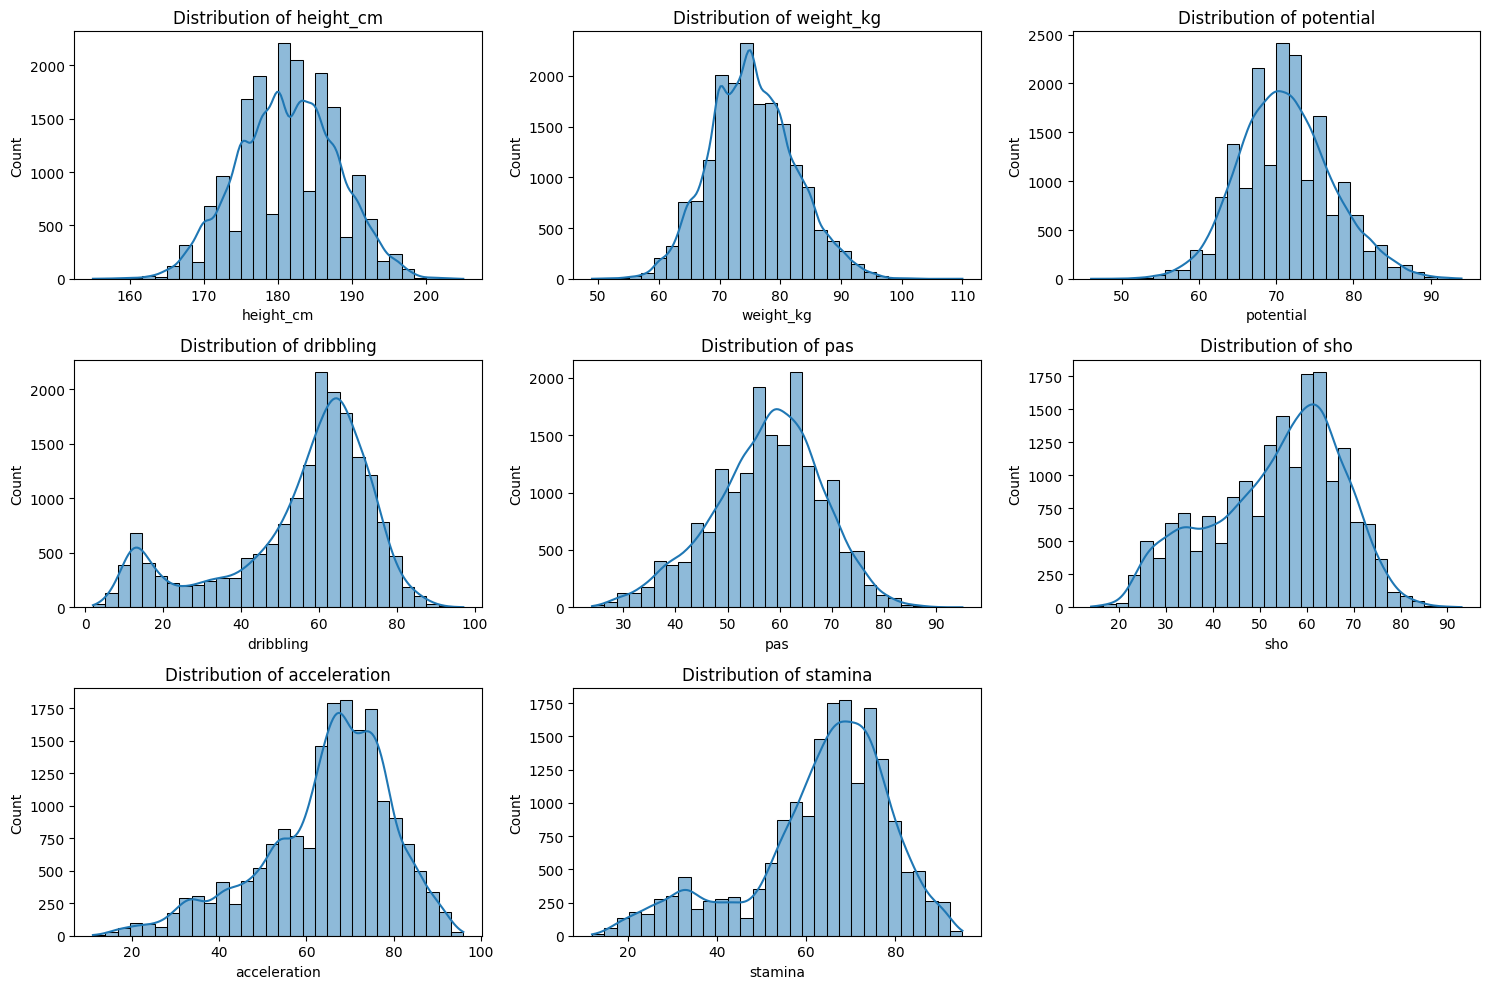

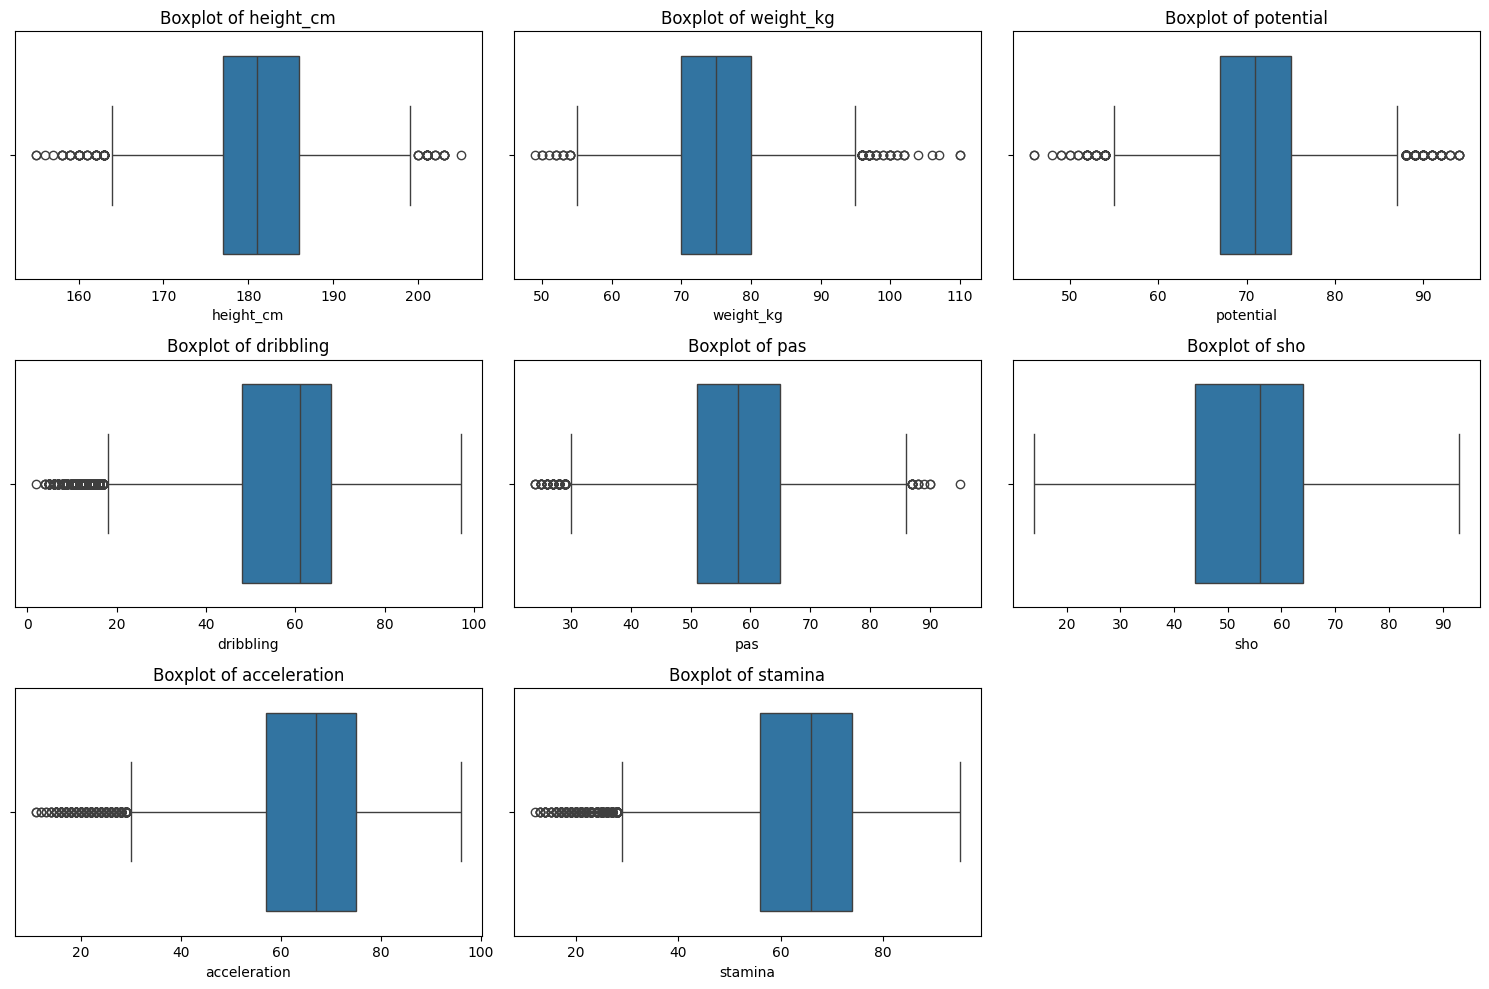

In [191]:
# Analyzing the distribution of numerical features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

# Display boxplots
plt.figure(figsize=(15, 10))

for i, feature in enumerate(selected_features):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x=df[feature])
    plt.title(f"Boxplot of {feature}")
plt.tight_layout()
plt.show()

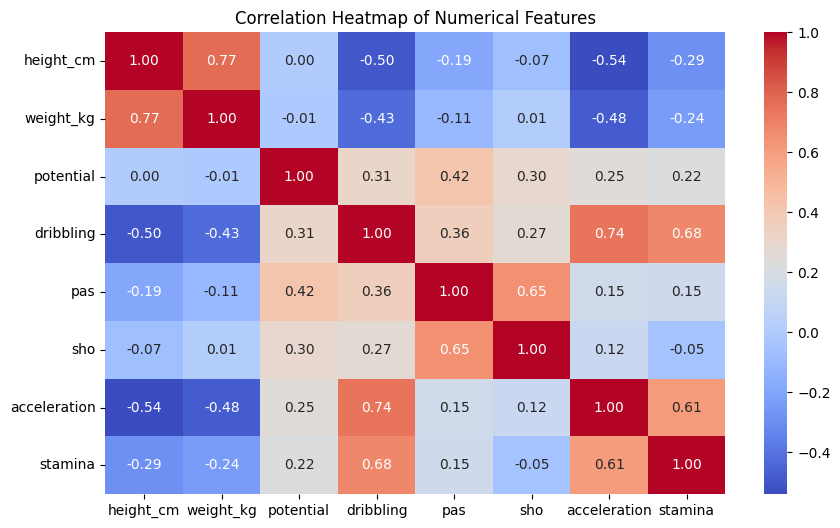

In [192]:
# Checking for correlations between numerical features
plt.figure(figsize=(10, 6))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

In [193]:
# Combine the preprocessed features with the target variable
preprocessed_df = X_scaled.copy()
preprocessed_df["overall_category"] = y_class.values

# Save the preprocessed dataset to a CSV file
preprocessed_df.to_csv("preprocessed_dataset.csv", index=False)

print("Preprocessed dataset saved successfully.")

Preprocessed dataset saved successfully.


Class distribution before balancing:
overall
1    4996
0    4823
2    4576
Name: count, dtype: int64


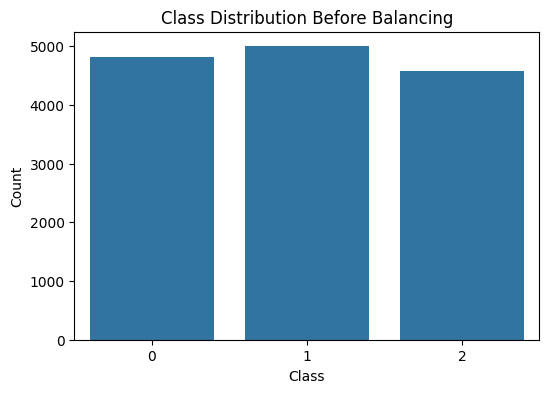

In [194]:
# Split data into training and testing sets (Before SMOTE)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)

# Ensure y_train is integer type before applying SMOTE
y_train = y_train.astype(int)

# Display class distribution before SMOTE
print("Class distribution before balancing:")
print(pd.Series(y_train).value_counts())

# Visualizing the class distribution before SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title("Class Distribution Before Balancing")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

Class distribution after balancing:
overall
0    4996
1    4996
2    4996
Name: count, dtype: int64


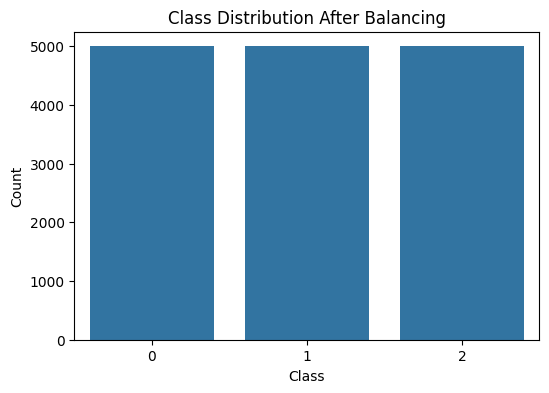

In [195]:
# Resampling using SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Display class distribution after SMOTE
print("Class distribution after balancing:")
print(pd.Series(y_train_resampled).value_counts())

# Visualizing the class distribution after SMOTE
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_resampled)
plt.title("Class Distribution After Balancing")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [196]:
# Train the Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    min_samples_split=300,
    min_samples_leaf=150,
    max_features='log2',
    bootstrap=False,
    random_state=42
)
rf_classifier.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(bootstrap=False, max_depth=10, max_features='log2',
                       min_samples_leaf=150, min_samples_split=300,
                       n_estimators=50, random_state=42)

In [203]:
# Make predictions
y_train_pred = rf_classifier.predict(X_train_resampled)
y_test_pred = rf_classifier.predict(X_test)

# Compute accuracy
train_acc = accuracy_score(y_train_resampled, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_acc}")
print(f"Testing Accuracy: {test_acc}")

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_test_pred))

Exact Training Accuracy: 0.8149853215906058
Exact Testing Accuracy: 0.801055848846902
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1202
           1       0.76      0.69      0.73      1246
           2       0.81      0.90      0.85      1151

    accuracy                           0.80      3599
   macro avg       0.80      0.80      0.80      3599
weighted avg       0.80      0.80      0.80      3599



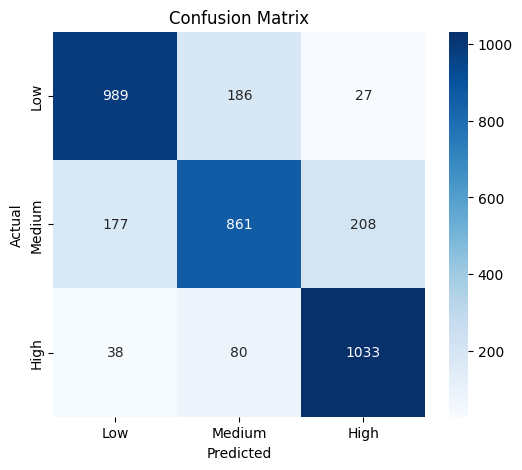

In [204]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "Medium", "High"], yticklabels=["Low", "Medium", "High"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

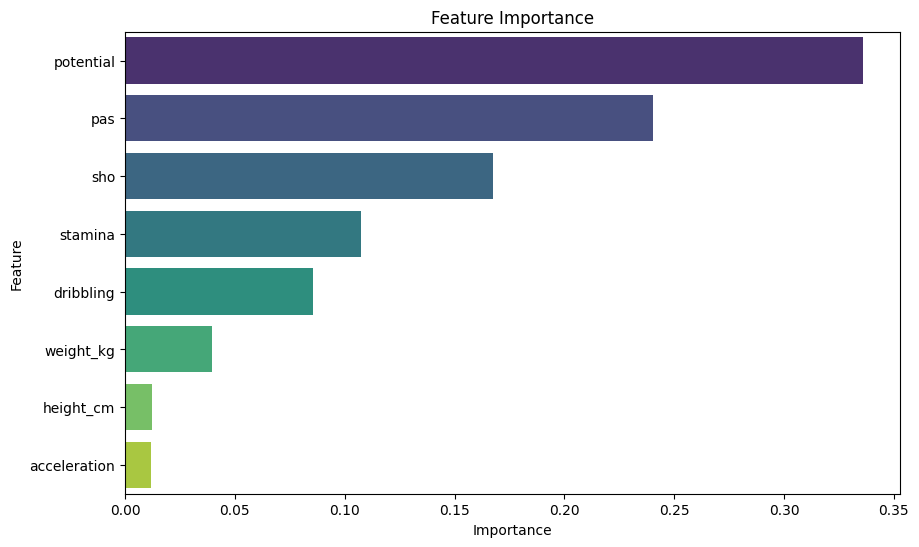

In [205]:
# Get the feature importances from the Random Forest model
importances = rf_classifier.feature_importances_

# Create a DataFrame to hold feature names and their importance values
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
})

# Sort the DataFrame based on importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance with the corrected usage
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis', hue='Feature')
plt.title("Feature Importance")
plt.legend([],[], frameon=False)  # Disable the legend
plt.show()

In [206]:
# Save the trained Random Forest model
joblib.dump(rf_classifier, "random_forest_model.pkl")

# Save the fitted scaler
joblib.dump(scaler, "scaler.pkl")

print("Model and scaler saved successfully.")

Model and scaler saved successfully.
